In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import japanize_matplotlib

# フォント設定
plt.rcParams['font.family'] = 'IPAexGothic'

# データベース接続
# SQLiteデータベースに接続し交通事故データを取得
conn = sqlite3.connect('/Users/mizuki/ds-programing2-2024/practice/traffic/traffic_data.db')

# 事故データの取得（完全な欠損行は除外）
accidents_df = pd.read_sql_query("SELECT * FROM traffic_accidents", conn)
accidents_df = accidents_df.dropna(how='all')

=== 標準化後のデータ（先頭5行） ===
  prefecture  accidents  deaths  injuries
0        北海道     569.00    3.00    640.00
1        北海道      50.00    0.00     58.00
2        北海道      64.00    1.00     73.00
3        北海道      54.00    2.00     55.00
4        北海道      27.00    0.00     31.00

人口密度と事故率の相関係数: 0.141


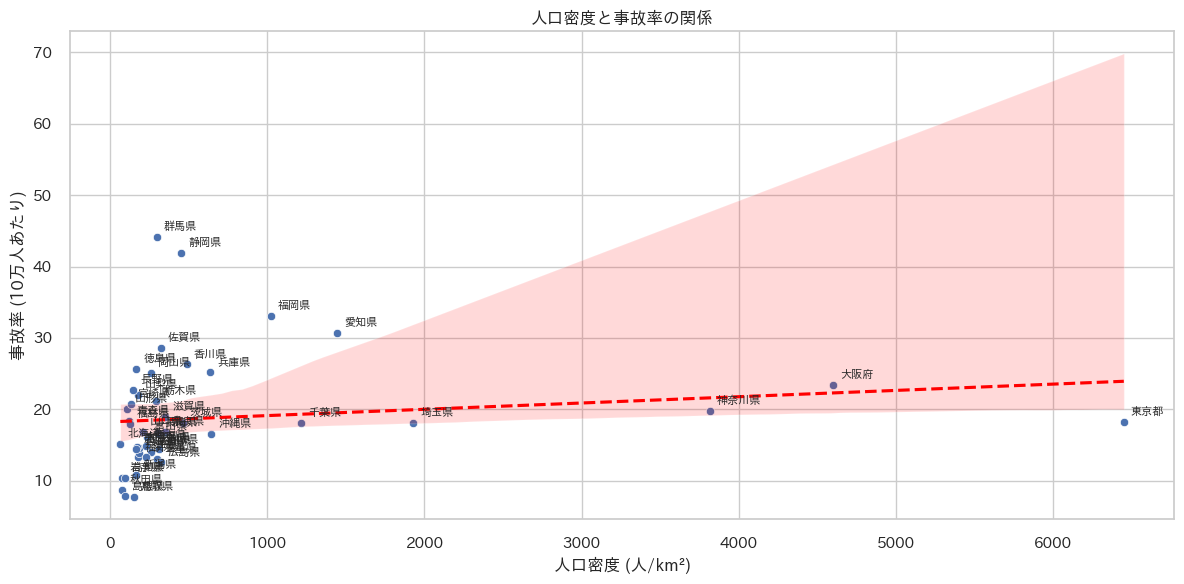

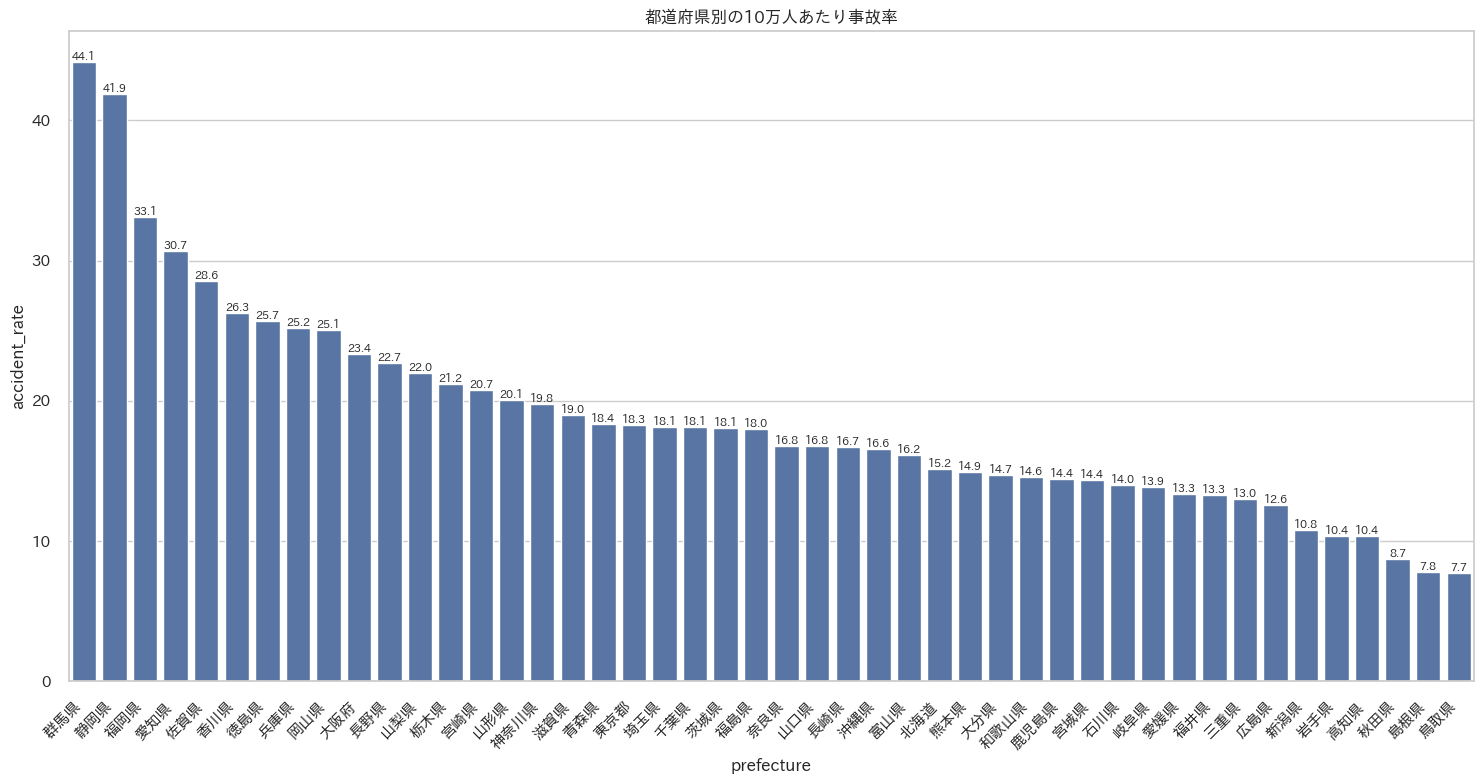


=== 基本統計 ===
       accident_rate  density  accidents  population
count          46.00    46.00      46.00       46.00
mean           18.82   652.17     546.39  2637510.85
std             7.77  1240.34     651.30  2840438.63
min             7.72    64.29      41.00   531085.00
25%            14.11   165.60     174.50  1015918.00
50%            17.39   245.89     234.00  1498634.00
75%            21.81   427.03     495.75  2599334.50
max            44.14  6451.17    2591.00 14192184.00

事故率が最も高い5都道府県:
   prefecture  accident_rate  density  accidents  population
9         群馬県          44.14   296.97     834.00     1889425
21        静岡県          41.91   453.15    1477.00     3524160
38        福岡県          33.11  1022.06    1688.00     5097710
22        愛知県          30.68  1443.06    2290.00     7465250
39        佐賀県          28.57   322.73     225.00      787675

事故率が最も低い5都道府県:
   prefecture  accident_rate  density  accidents  population
29        鳥取県           7.72   151.43      41.00  

In [44]:
# 都道府県名の標準化関数
# 都道府県名を統一された形式に変換する
def standardize_prefecture(name):
    if pd.isna(name):
        return None
        
    # 北海道の市を北海道に変換
    hokkaido_cities = ['札幌', '函館', '旭川', '釧路', '北見']
    if name in hokkaido_cities:
        return '北海道'
    
    # 都府県名の標準化
    # 都府県名の末尾に「都」「府」「県」が付いている場合は除去
    name = name.replace('県', '').replace('府', '').replace('都', '')
    if name == '北海道':
        return name
    elif name in ['東京', '京都', '大阪']:
        return name + '府' if name in ['京都', '大阪'] else name + '都'
    else:
        return name + '県'
    
# 都道府県名の標準化を適用
accidents_df.loc[:, 'prefecture'] = accidents_df['prefecture'].apply(standardize_prefecture)

# 集計前のデータ確認
print("=== 標準化後のデータ（先頭5行） ===")
print(accidents_df.head())

# 事故件数、死亡者数、負傷者数を都道府県別に集計
accidents_grouped = accidents_df.groupby('prefecture', as_index=False).agg({
    # 事故総数
    'accidents': 'sum',
    # 死亡者総数
    'deaths': 'sum',
    # 負傷者総数
    'injuries': 'sum'
}).dropna()

# 人口データの取得
# 都道府県別の人口と人口密度データを取得
population_df = pd.read_sql_query("""
    SELECT prefecture, population, density 
    FROM population_data
""", conn)

# データの結合
# 事故データと人口データを都道府県名で結合する
merged_df = pd.merge(population_df, accidents_grouped, on='prefecture', how='inner')

# 10万人あたりの事故発生率を計算
merged_df['accident_rate'] = merged_df['accidents'] / merged_df['population'] * 100000

# 人口密度と事故率の相関を計算
correlation = merged_df['density'].corr(merged_df['accident_rate'])
print(f"\n人口密度と事故率の相関係数: {correlation:.3f}")

# 相関分析
# 散布図で可視化する
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='density', y='accident_rate')
# 回帰直線を追加
sns.regplot(data=merged_df, x='density', y='accident_rate', 
           scatter=False, color='red', line_kws={'linestyle': '--'})

# 都道府県名のラベルを追加
for _, row in merged_df.iterrows():
    plt.annotate(row['prefecture'], 
                (row['density'], row['accident_rate']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.title('人口密度と事故率の関係')
plt.xlabel('人口密度 (人/km²)')
plt.ylabel('事故率 (10万人あたり)')
plt.tight_layout()
plt.show()

# 都道府県別事故率の棒グラフ
plt.figure(figsize=(15, 8))
# 事故率の高い順にソートして可視化
chart = sns.barplot(data=merged_df.sort_values('accident_rate', ascending=False),
                   x='prefecture', y='accident_rate')
plt.title('都道府県別の10万人あたり事故率')
plt.xticks(rotation=45, ha='right')

# 棒グラフ上に数値を表示
for i, bar in enumerate(chart.patches):
    chart.text(i, bar.get_height(), f'{bar.get_height():.1f}', 
              ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 結果の表示
# 基本統計量の表示
print("\n=== 基本統計 ===")
print(merged_df[['accident_rate', 'density', 'accidents', 'population']].describe())

# 事故率が最も高い5都道府県と最も低い5都道府県を表示
print("\n事故率が最も高い5都道府県:")
print(merged_df.nlargest(5, 'accident_rate')[['prefecture', 'accident_rate', 'density', 'accidents', 'population']])

print("\n事故率が最も低い5都道府県:")
print(merged_df.nsmallest(5, 'accident_rate')[['prefecture', 'accident_rate', 'density', 'accidents', 'population']])

conn.close()

# 交通事故データの分析

### データの準備と前処理を行う

#### 使用データ
- 交通事故発生状況データ(traffic_accidentsテーブル)  
都道府県別の交通事故件数、死亡者数、負傷者数
- 人口データ(population_dataテーブル)  
都道府県別の人口、人口密度など


#### データクリーニング
- 全ての列が欠損の行を削除
- 日本語で表示するためにフォントを設定する

### データの標準化を行う

#### 都道府県名を標準化
- 北海道の都市（札幌、函館など）を北海道として統一する  
- 都道府県名の表記を統一する  
東京を東京都、京都を京都府にする  
- 欠損値の処理

### データの集計と結合を行う

#### 交通事故データを集計
- 都道府県別に項目を集計する  
事故の総数、死亡者の総数、負傷者の総数

#### データの結合
- 交通事故のデータと人口のデータを都道府県名をキーとして結合する
- 内部結合を使用して両方のデータセットに存在する都道府県のみを保持した

### 分析指標の算出を行う

#### 交通事故率の計算
- 10万人あたりの交通事故件数を算出する  
事故件数を人口で割りその数に10万をかける  
#### 相関分析
- 人口密度と交通事故率の相関係数を計算する  
- 量変数間の関係性を定量的に評価する  
### データの可視化  
#### 散布図による相関分析  
- X軸は人口密度を表している  
- Y軸は交通事故率を表している  
- 各点に都道府県名をラベル付けし、回帰直線の追加による傾向の可視化を行う  
#### 交通事故率の都道府県を比較  
- 棒グラフによる可視化を行う  
事故率の高い順にして各棒グラフ上に具体的な数値を表示させる。  
- 都道府県間の事故率の差異を視覚的に比較する  

### 分析結果  
#### 基本統計量  
- 事故率
- 人口密度
- 事故件数
- 人口  
平均値、標準偏差、最小値、中央値、最大値  
#### 特徴的な都道府県の抽出
- 事故率が最も高い都道府県5つを特定し分析する
- 事故率が最も低い都道府県5つを特定し分析する
### 分析から考えられることや知見
- 人口密度と事故率の関係性について  
人口密度と事故率の相関係数は低くなった。人口密度が高いからと言って交通事故の件数も増えるわけではないことがわかった。
- 地域の特性と事故率の関連について  
上記のことから交通事故の件数は地域の特性と関連するのではないかと考えられる。分析を行った中で地方の方が事故の件数が多かったため自動車の使用率や土地の特性をデータに新しく組み込むことでより良い分析結果が見られるのではないかと考えた。